In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile

In [66]:
with open('../sdr/audio/iq', 'rb') as input_file:
    data = np.fromfile(input_file, dtype=np.int16)
data = np.reshape(data, (-1, 2))
iq_samples = data[:, 0] + 1j * data[:, 1]

In [71]:
with open('../sdr/audio/decimated', 'rb') as input_file:
    data = np.fromfile(input_file, dtype=np.int16)
data = np.reshape(data, (-1, 2))
dec_samples = data[:, 0] + 1j * data[:, 1]

In [64]:
with open('../sdr/audio/decimated_fir', 'rb') as input_file:
    data = np.fromfile(input_file, dtype=np.int16)
data = np.reshape(data, (-1, 2))
fir_samples = data[:, 0] + 1j * data[:, 1]

/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


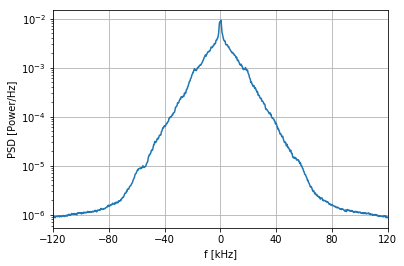

In [65]:
welch(fir_samples, sample_rate_fm)

### Compute Welch estimate without detrending.

In [61]:
def welch(samples, sample_rate):
    f, Pxx = signal.welch(samples, sample_rate, nperseg=1024, detrend=lambda x: x)
    f, Pxx = fftshift(f), fftshift(Pxx)

    plt.semilogy(f/1e3, Pxx)
    plt.xlabel('f [kHz]')
    plt.ylabel('PSD [Power/Hz]')
    plt.grid()

    plt.xticks(np.linspace(-sample_rate/2e3, sample_rate/2e3, 7))
    plt.xlim(-sample_rate/2e3, sample_rate/2e3)

/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


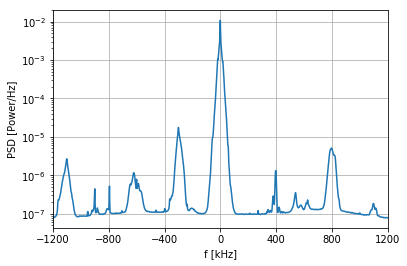

In [67]:
sample_rate = 2400000
welch(iq_samples, sample_rate)

### Decimation with Butterworth filter.

In [68]:
sample_rate_fm = 240000  # decimate by 10
iq_decim = signal.decimate(iq_samples, sample_rate // sample_rate_fm)

/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


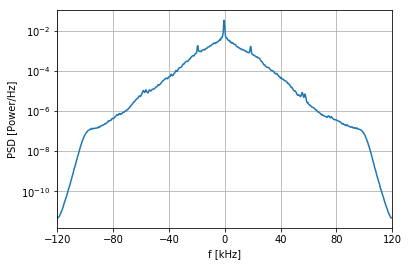

In [69]:
welch(iq_decim, sample_rate_fm)

### Demodulate.
Calculate angle - modulated signal phase, then estimate the derivative, which - up to a constant - is the modulating signal.

In [74]:
angle_comercial = np.unwrap(np.angle(fir_samples))
demodulated_comercial = np.diff(angle_comercial)

Decimate again to 48kHz.

In [75]:
audio_rate = 48000
audio_comercial = signal.decimate(demodulated_comercial, sample_rate_fm // audio_rate, zero_phase=True)

/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [76]:
audio_comercial = np.int16(1e4*audio_comercial)
wavfile.write("df.wav", rate=audio_rate, data=audio_comercial)

## Now we want to demodulate it in a simplest possible manner.

Square window (boxcar) for a low pass filter. Baseband delay demodulation. Plain downsampling after demodulation.

In [72]:
sample_rate_fm = 240000  # decimate by 10
audio_rate = 48000

def decimate(samples, M):
    lp_len = samples.shape[0] // M
    lp_samples = np.empty(shape=(lp_len, ), dtype=samples.dtype)
    
    for i in range(lp_len):
        lp_samples[i] = samples[(i + 1) * M - 10: (i + 1) * M].sum()
        
    return lp_samples

iq_decimated = decimate(iq_samples, sample_rate // sample_rate_fm)

/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


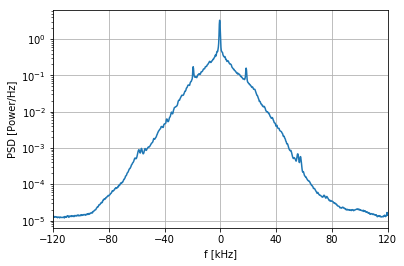

In [73]:
welch(iq_decimated, sample_rate_fm)

In [14]:
def demodulate(samples):
    dm_samples = np.empty(shape=(len(samples) - 1, ))
    
    for i in range(len(dm_samples)):
        angle_c = np.arctan2(samples[i + 1].real, samples[i + 1].imag)
        angle_p = np.arctan2(samples[i].real, samples[i].imag)
        dm_samples[i] = angle_c - angle_p
    
    return dm_samples

In [15]:
demodulated = demodulate(iq_decimated)

audio = demodulated[::5]
audio = np.int16(1e4 * audio)
wavfile.write("boxcar.wav", rate=audio_rate, data=audio)